In [95]:
# Start with loading all necessary libraries
import pandas as pd
import random
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Let's read in the data and convert prices to numeric values
listings = pd.read_csv('data/listings.csv.gz', compression='gzip')
listings['price'] = listings['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Are there differences in the descriptions of listings between the upper and lower pricings?

The host of a listing is free to describe it however they'd like. Text fields are always a great source of raw data to explore as it doesn't have to adhere to a tabular structure and can be rich in information. In this notebook, we'll explore the descriptions of listings and see if there are any differences between the upper and lower pricings. 

Let's start off by defining which quantiles we want to use for the upper and lower pricings. We'll go for 0.9 and 0.1, respectively to limit the amount of listings.

In [6]:
listings_upper = listings[listings['price']>listings['price'].quantile(0.9)]
listings_lower = listings[listings['price']<listings['price'].quantile(0.1)]

We have to do some preprocessing. As mentioned these are text fields that can contain anything that the host might put in it, therefore some filtering is in place to limit the amount of different tokens.

We'll start off by removing certain HTML tags, use regex to remove any punctuation (periods, commas, etc.)) and lower-casing all the words.

In [74]:
def preprocess(description_series):
    s = " ".join(description_series.fillna("").to_list())
    s = s.replace("<br />", " ").replace("<b>", " ").replace("</b>", " ")
    s = re.sub(r'[^\w\s]', '', s)
    s = s.lower()
    return s

In [75]:
text_upper = preprocess(listings_upper['description'])
text_lower = preprocess(listings_lower['description'])

To get an overview of the most common words, we'll introduce a word cloud. This is a great way to get an overview of the most common words in a text. We'll compare the words in description of the upper and lower pricing listings.

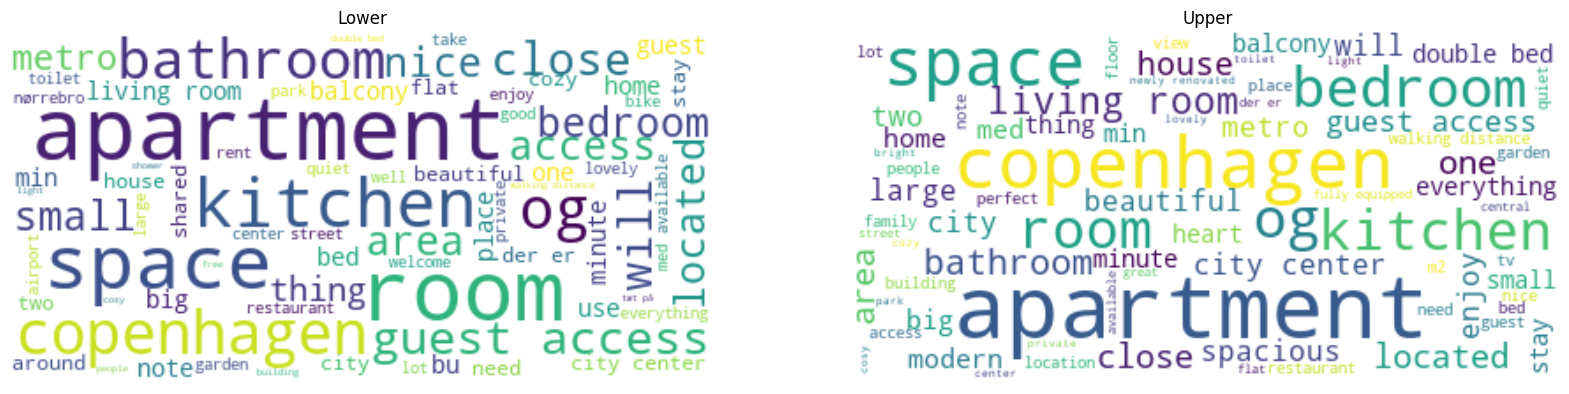

In [87]:
# Create and generate a word cloud image:
wordcloud_l = WordCloud(max_font_size=50, max_words=75, background_color="white").generate(text_lower)
wordcloud_u = WordCloud(max_font_size=50, max_words=75, background_color="white").generate(text_upper)

# Display the generated image:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(wordcloud_l, interpolation="bilinear")
axs[0].axis("off")
axs[0].set_title('Lower')
axs[1].imshow(wordcloud_u, interpolation="bilinear")
axs[1].axis("off")
axs[1].set_title('Upper')
plt.show()

It is immediately noticable that there is a lot of overlap between the two wordclouds. Some of the exclusive words are, for the upper listings "Modern", "Quiet", "Spacious" while for the lower listings "Cozy", "Airport", "Metro" and "Nørrebro". The lower listings seems to cater to tourists who will be exploring the city and not be much at the listing itself.

Given the large overlap, we want to quantify how much overlap there actually is. For this we can use the Jaccard similarity. This is a measure of how similar two sets are, so in essence how many words are common between the two lists of words.

In [78]:
# https://pyshark.com/jaccard-similarity-and-jaccard-distance-in-python/
def jaccard_similarity(A, B):
    #Find intersection of two sets
    nominator = A.intersection(B)

    #Find union of two sets
    denominator = A.union(B)

    #Take the ratio of sizes
    similarity = len(nominator)/len(denominator)
    
    return similarity

jaccard_similarity(set(text_upper.split()), set(text_lower.split()))

0.34869379014989293

We can see that there is a 35% overlap between the two sets of words. How about those words that are exclusive to the upper and lower listings? Let's check those out.

We use set operations to get the words that are exclusive to the upper and lower listings. We also perform a value count to get the count of each word. This is then combined into a list where each word that is exclusive to the upper and lower listings is present as many times as it occurs in the original text.

In [97]:
upper_exclusive_set = set(text_upper.split()).difference(set(text_lower.split()))
lower_exclusive_set = set(text_lower.split()).difference(set(text_upper.split()))

upper_VC = pd.Series(text_upper.split()).value_counts()
lower_VC = pd.Series(text_lower.split()).value_counts()

lower_exclusive = [x for y in [[word]*lower_VC[word] for word in lower_exclusive_set] for x in y]
random.shuffle(lower_exclusive)
upper_exclusive = [x for y in [[word]*upper_VC[word] for word in upper_exclusive_set] for x in y]
random.shuffle(upper_exclusive)

In [98]:
# sanity check, should be 0
jaccard_similarity(upper_exclusive_set, lower_exclusive_set)

0.0

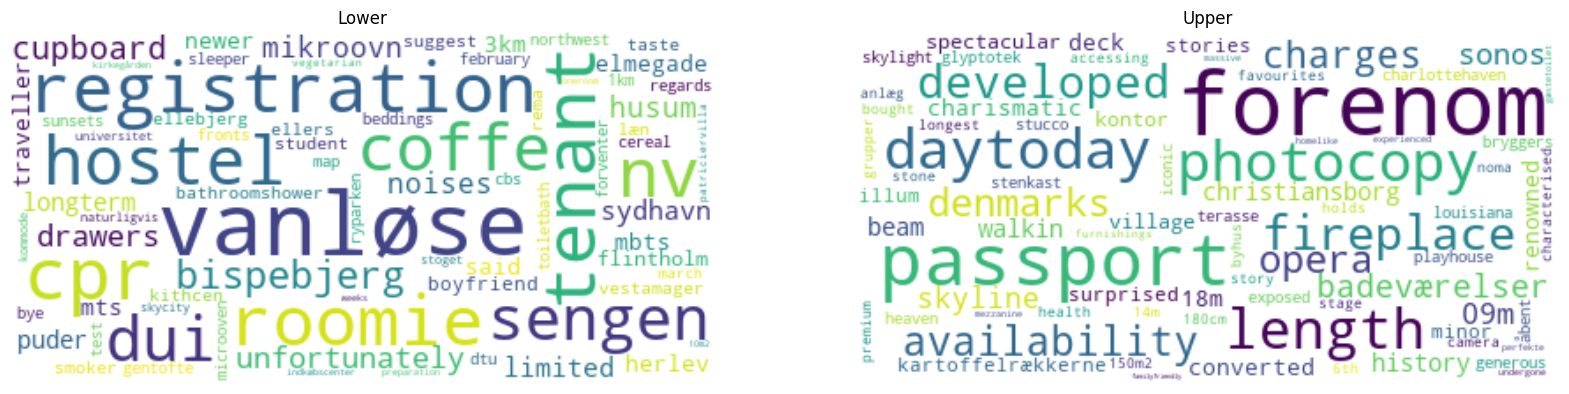

In [101]:
wordcloud_l = WordCloud(max_font_size=50, max_words=75, background_color="white").generate(" ".join(lower_exclusive))
wordcloud_u = WordCloud(max_font_size=50, max_words=75, background_color="white").generate(" ".join(upper_exclusive))

# Display the generated image:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(wordcloud_l, interpolation="bilinear")
axs[0].axis("off")
axs[0].set_title('Lower')
axs[1].imshow(wordcloud_u, interpolation="bilinear")
axs[1].axis("off")
axs[1].set_title('Upper')
plt.show()

Cool! We see that words like "Vanløse", "CPR", "Traveller" and "Roomie" are exclusive and prominent to the descriptions of the lower priced listings. However, in the upper priced listings we see something weird. "Forenom", "Photocopy", "Passport" - what is with these words? Let's check out the listings that contain these words.

In [140]:
descriptions = listings['description'].fillna("")
print(descriptions[descriptions.str.contains("Forenom")].iloc[0] + "\n")
print(descriptions[descriptions.str.contains("Forenom")].iloc[1] + "\n")
print(descriptions[descriptions.str.contains("Forenom")].iloc[2] + "\n")

Newly renovated, wonderful, bright one-bedroom apartment in the heart of city center. This apartment is stylish and furnished in a modern fashion. The apartment includes a beautiful new kitchen with all appliances, nice dining and living area, TV and Internet access. Only 30 minutes by public transport from the Copenhagen airport, and located within walking distance to all the Copenhagen attractions. The apartment is fully furnished and you can find dishes in the kitchen so that you can have breakfast and prepare dinner. Services to help your day-to-day life (for example, cleaning services) are also available to the apartment. Forenom may request a photocopy of the guest’s passport in advance. Please send a copy of the passport to Forenom within the requested time period. If you wish to book for another individual, please contact Forenom directly for further information after booking. Please note that all special requests are subject to availability, and additional charges may apply. P

We see that apart from a personalised description of the listing, they all end with a generic message:
> "The apartment is fully furnished and you can find dishes in the kitchen so that you can have breakfast and prepare dinner. Services to help your day-to-day life (for example, cleaning services) are also available to the apartment. Forenom may request a photocopy of the guest’s passport in advance. Please send a copy of the passport to Forenom within the requested time period. If you wish to book for another individual, please contact Forenom directly for further information after booking."


In [151]:
e = [t for t in expensive if t in pd.Series(expensive).value_counts()[(pd.Series(expensive).value_counts() < 50)]]

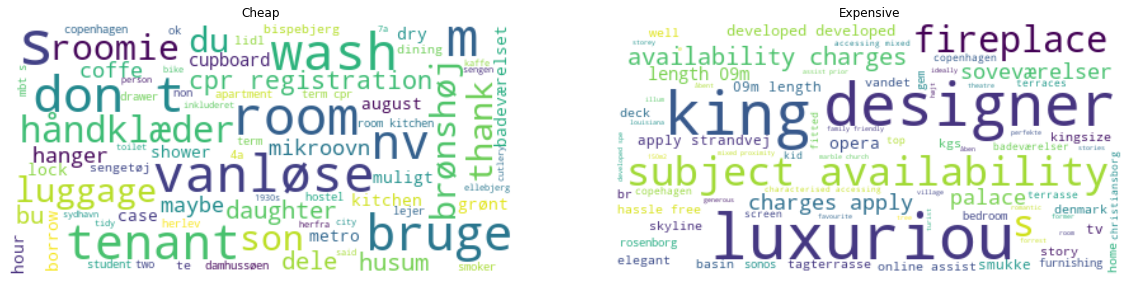

In [152]:
wordcloud_c = WordCloud(max_font_size=50, max_words=75, background_color="white").generate(" ".join(cheap))
wordcloud_e = WordCloud(max_font_size=50, max_words=75, background_color="white").generate(" ".join(e))

# Display the generated image:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(wordcloud_c, interpolation="bilinear")
axs[0].axis("off")
axs[0].set_title('Cheap')
axs[1].imshow(wordcloud_e, interpolation="bilinear")
axs[1].axis("off")
axs[1].set_title('Expensive')
plt.show()